<a href="https://colab.research.google.com/github/Imperial-Business-School/python-for-finance-adyachetiya/blob/main/PythonIndividualAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import yfinance as yf
import pandas as pd

# Choosing 10 global stocks
stocks = ['SONY', 'SPOT', 'DIS', 'NFLX', 'NWSA', 'NYT', 'TTWO', 'GOOGL', 'AMZN', 'JNJ']

# Download 5 years of daily data
data = yf.download(stocks, start='2020-01-01', end='2024-12-31')['Close']

# Save as CSV
data.to_csv('stock_data.csv')

# Load it back to confirm
df = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)
df.head()

/tmp/ipython-input-28-3953428596.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start='2020-01-01', end='2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


,AMZN,DIS,GOOGL,JNJ,NFLX,NWSA,NYT,SONY,SPOT,TTWO
Date,,,,,,,,,,
2020-01-02,94.900497,146.391525,68.026031,124.983688,329.809998,13.628749,31.045750,13.654090,151.619995,122.080002
2020-01-03,93.748497,144.712280,67.670143,123.536659,325.899994,13.590995,31.217224,13.460329,152.500000,122.209999
2020-01-06,95.143997,143.872650,69.473846,123.382576,335.829987,13.553242,31.264851,13.663973,156.720001,124.690002
2020-01-07,95.343002,143.922028,69.339645,124.136009,330.750000,13.685380,30.969088,13.879482,156.020004,125.510002
2020-01-08,94.598503,143.625702,69.833183,124.118904,339.260010,13.723131,31.045416,13.930887,158.779999,127.820000


In [9]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values with forward fill, common for price data
df_clean = df.fillna(method='ffill')

# Verify no missing values remain
print(df_clean.isnull().sum())

AMZN     0
DIS      0
GOOGL    0
JNJ      0
NFLX     0
NWSA     0
NYT      0
SONY     0
SPOT     0
TTWO     0
dtype: int64
AMZN     0
DIS      0
GOOGL    0
JNJ      0
NFLX     0
NWSA     0
NYT      0
SONY     0
SPOT     0
TTWO     0
dtype: int64


/tmp/ipython-input-9-1531450317.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df.fillna(method='ffill')


                 AMZN         DIS      GOOGL         JNJ        NFLX  \
Date                                                                   
2020-01-02  94.900497  146.391525  68.026031  124.983688  329.809998   
2020-01-03  93.748497  144.712280  67.670143  123.536659  325.899994   
2020-01-06  95.143997  143.872650  69.473846  123.382576  335.829987   
2020-01-07  95.343002  143.922028  69.339645  124.136009  330.750000   
2020-01-08  94.598503  143.625702  69.833183  124.118904  339.260010   

                 NWSA        NYT       SONY        SPOT        TTWO  
Date                                                                 
2020-01-02  13.628749  31.045750  13.654090  151.619995  122.080002  
2020-01-03  13.590995  31.217224  13.460329  152.500000  122.209999  
2020-01-06  13.553242  31.264851  13.663973  156.720001  124.690002  
2020-01-07  13.685380  30.969088  13.879482  156.020004  125.510002  
2020-01-08  13.723131  31.045416  13.930887  158.779999  127.820000  
     

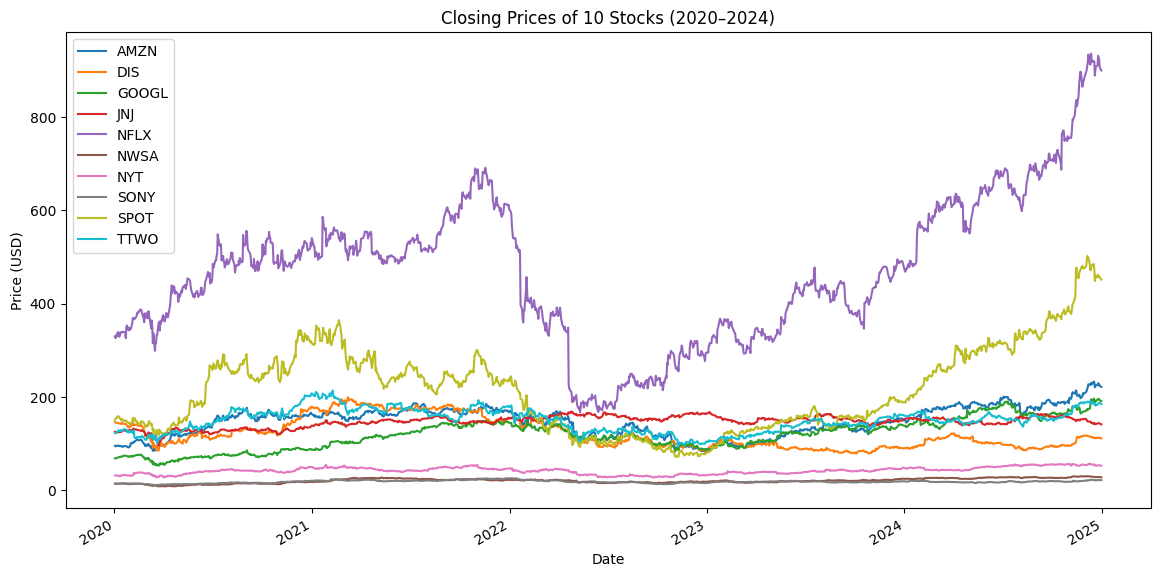

In [10]:
# Show head and tail
print(df_clean.head())
print(df_clean.tail())

# Plot all closing prices
import matplotlib.pyplot as plt

df_clean.plot(figsize=(14, 7))
plt.title("Closing Prices of 10 Stocks (2020–2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

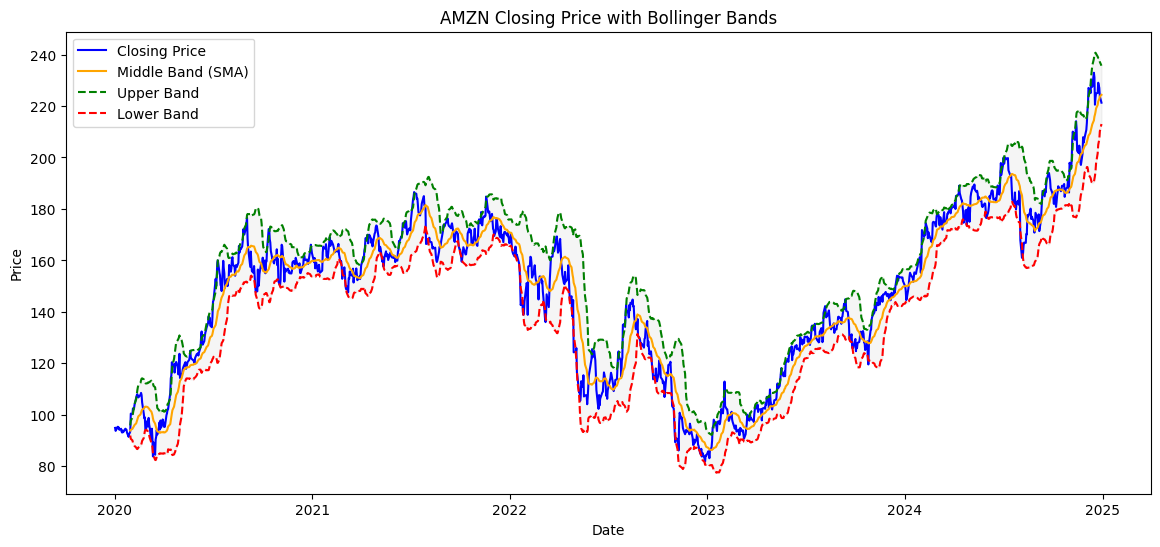

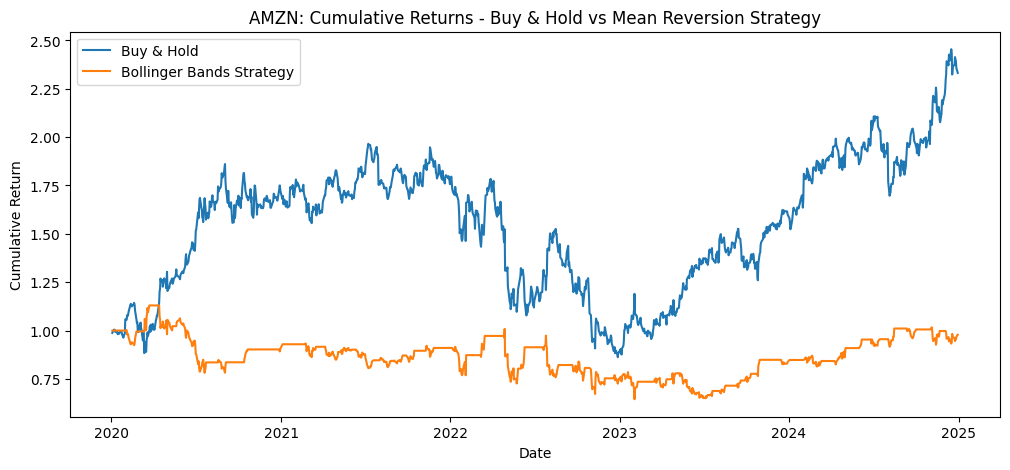

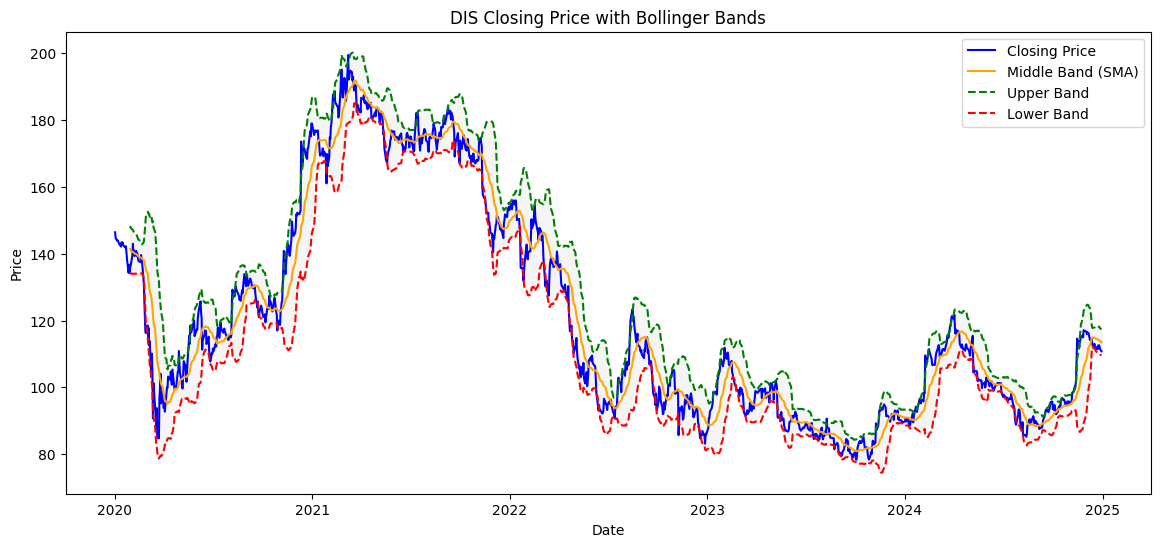

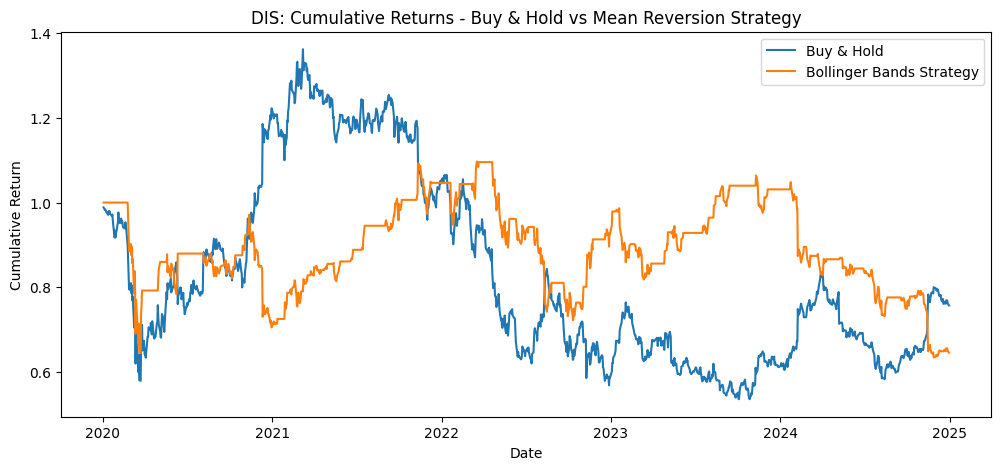

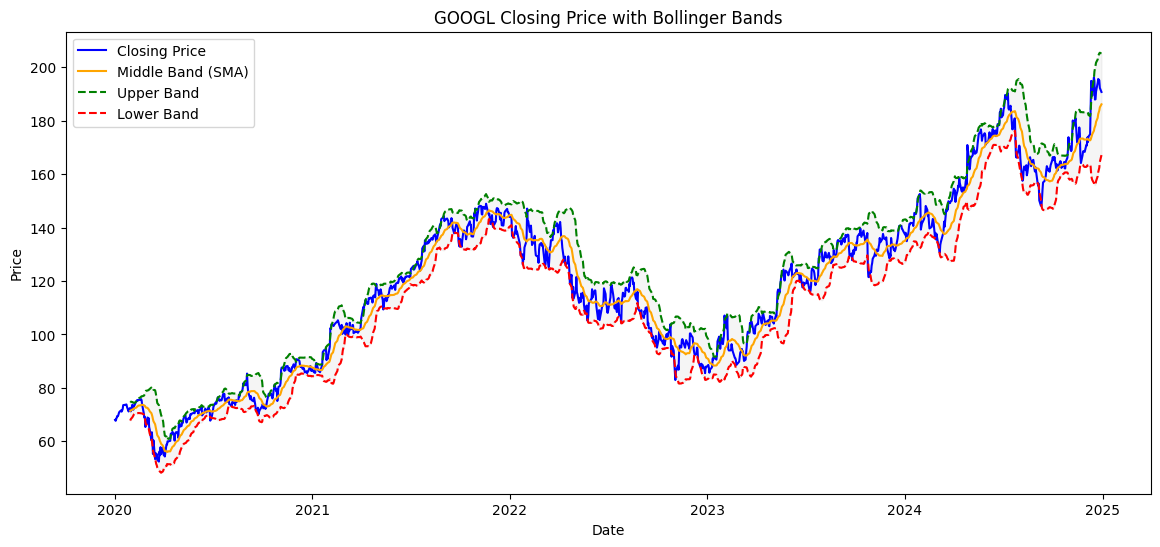

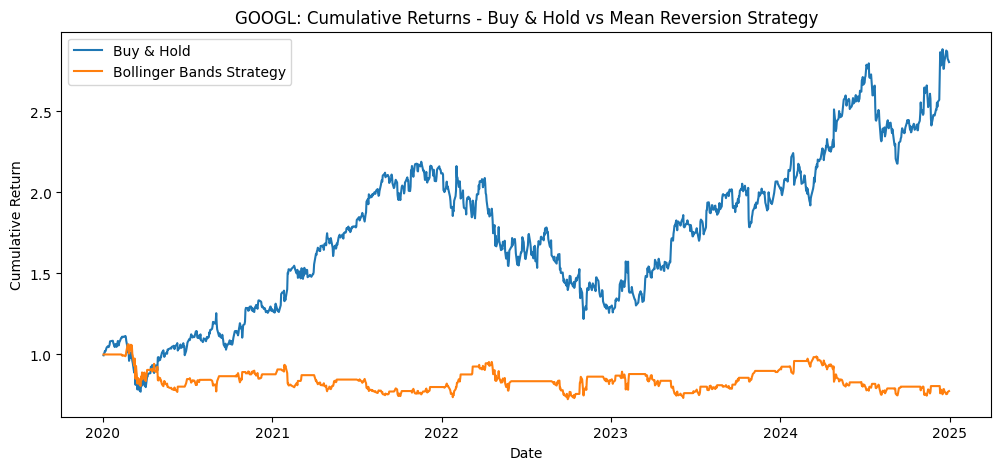

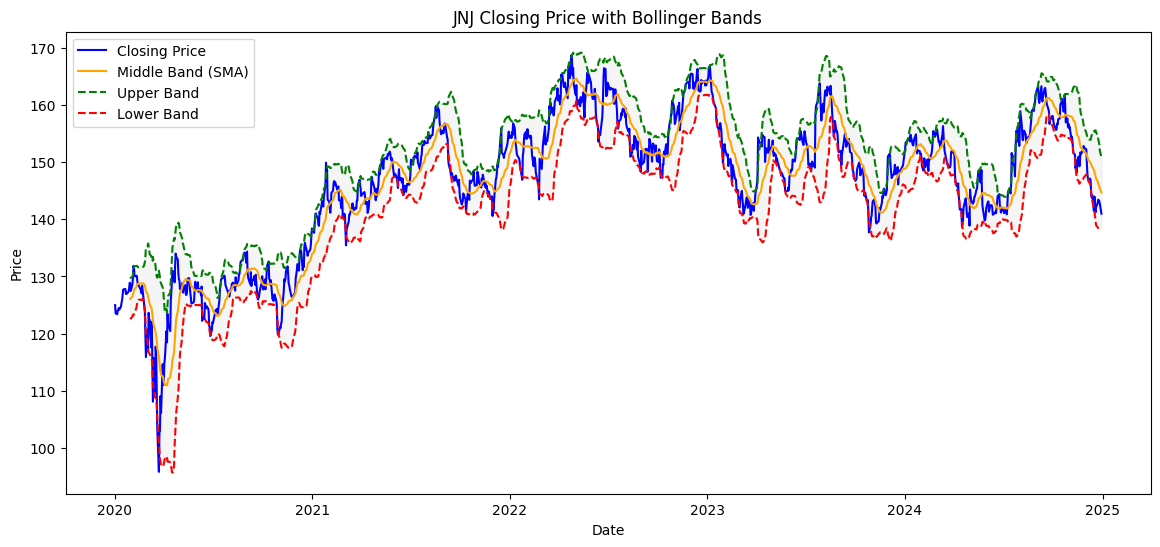

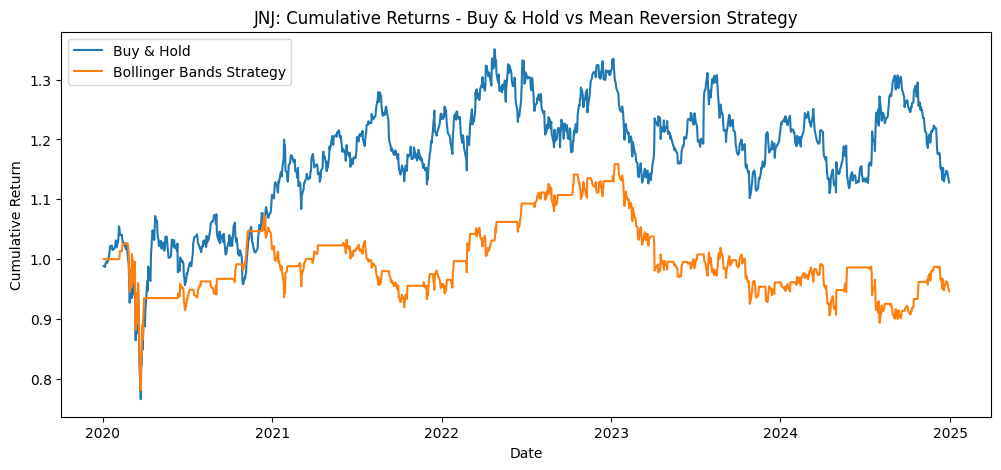

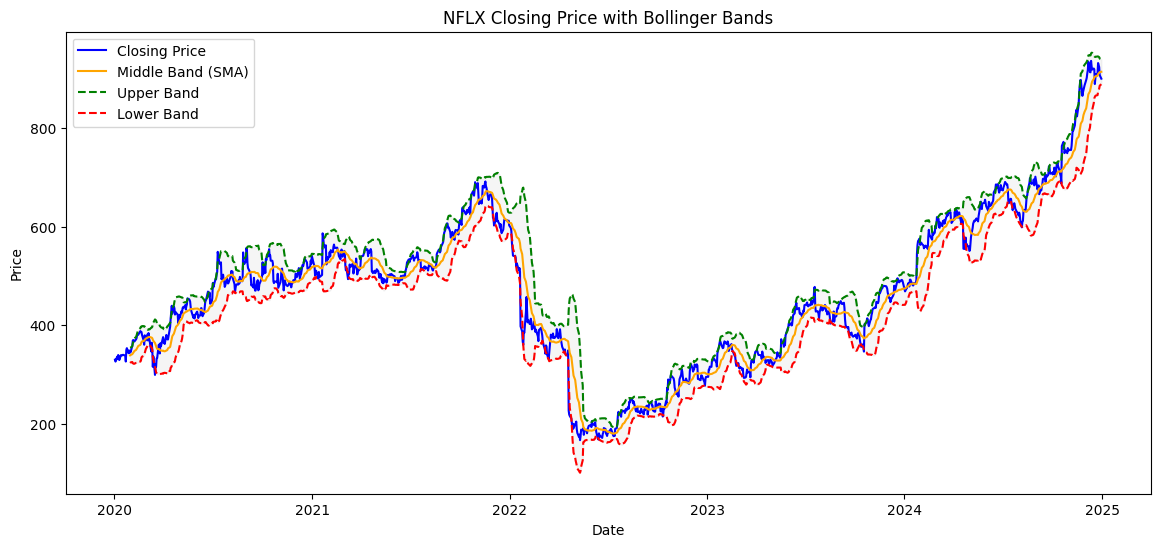

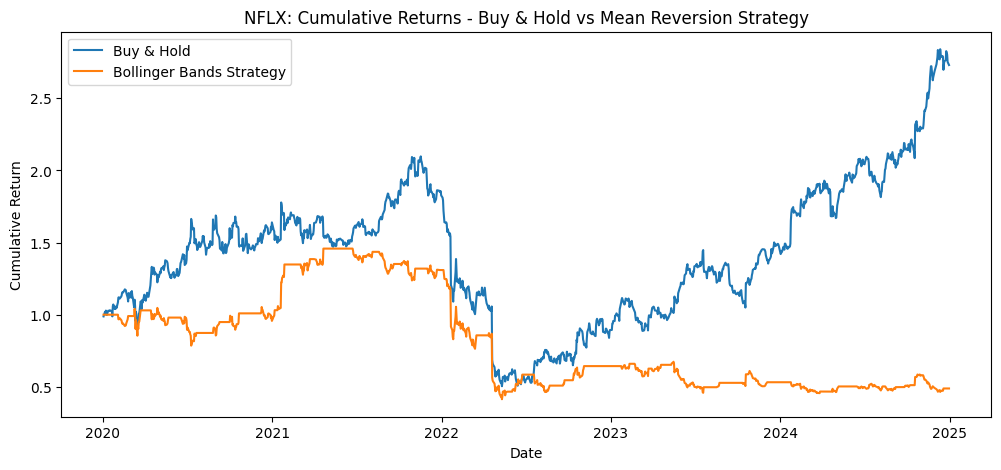

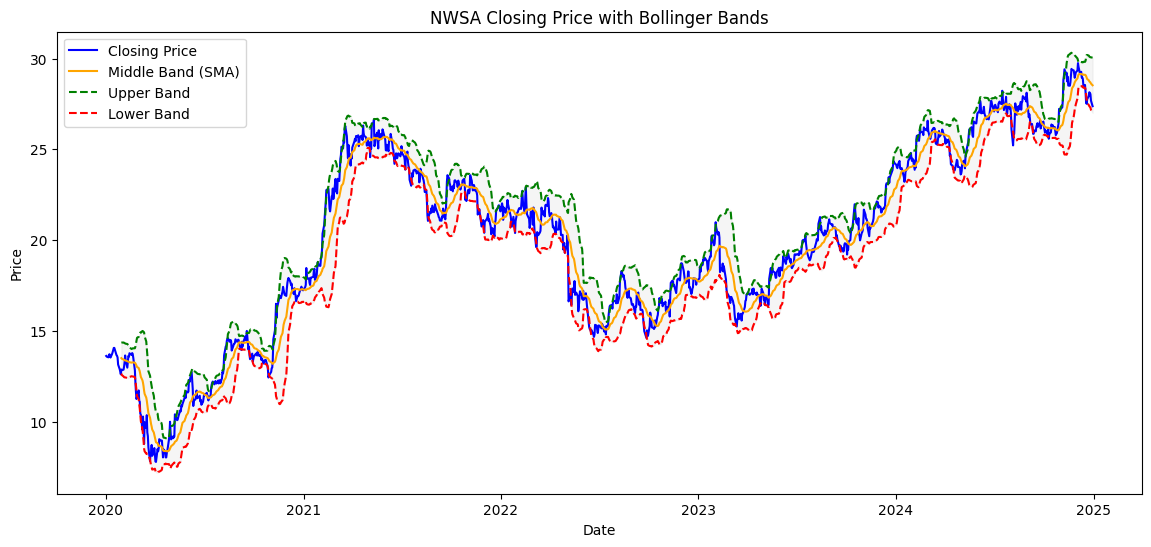

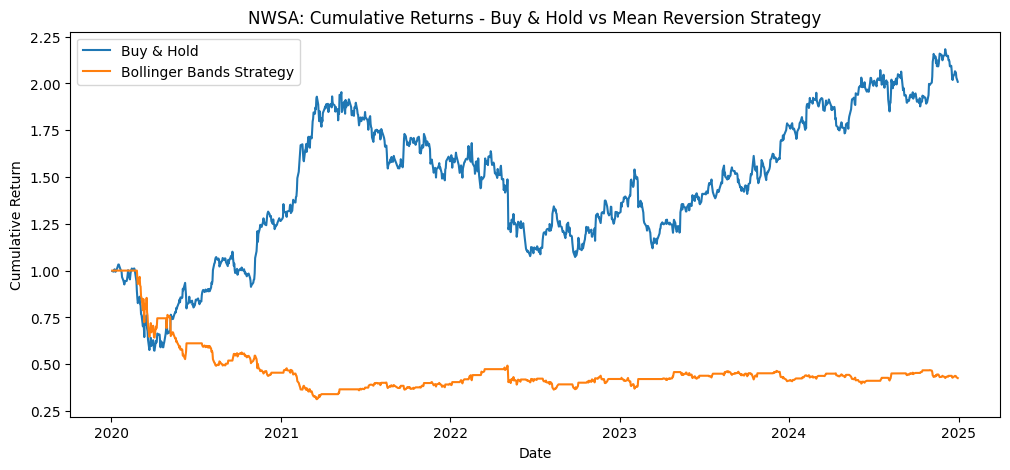

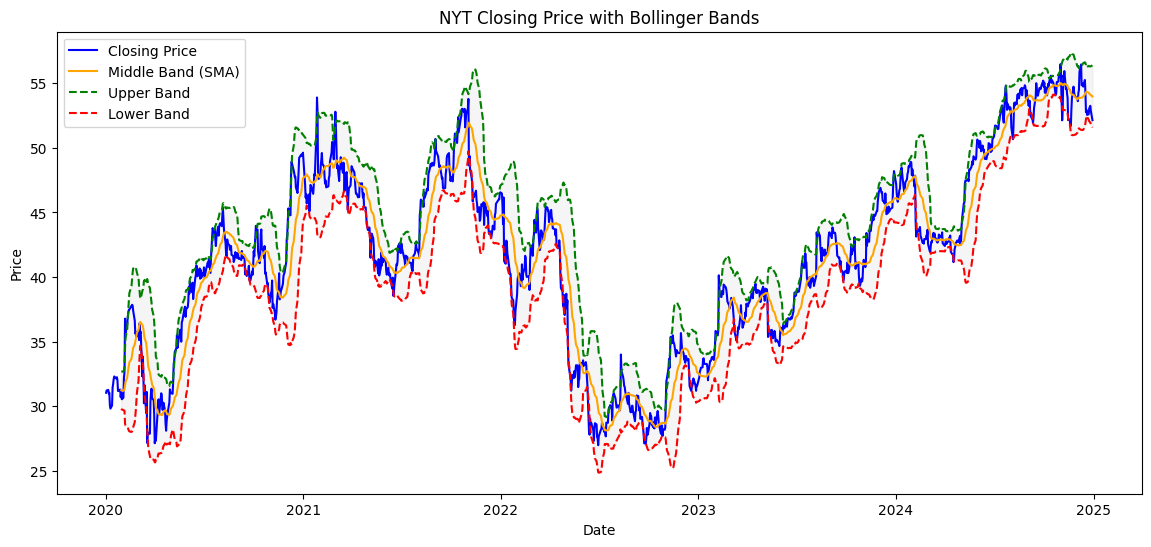

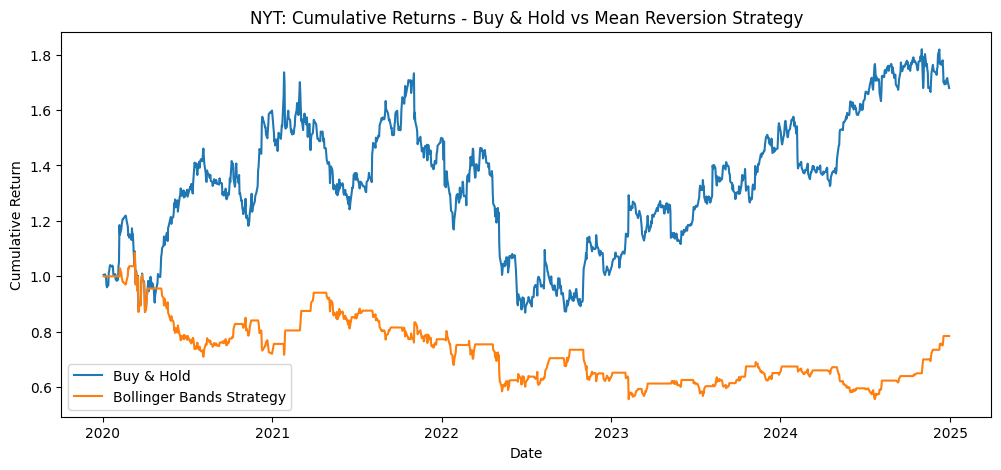

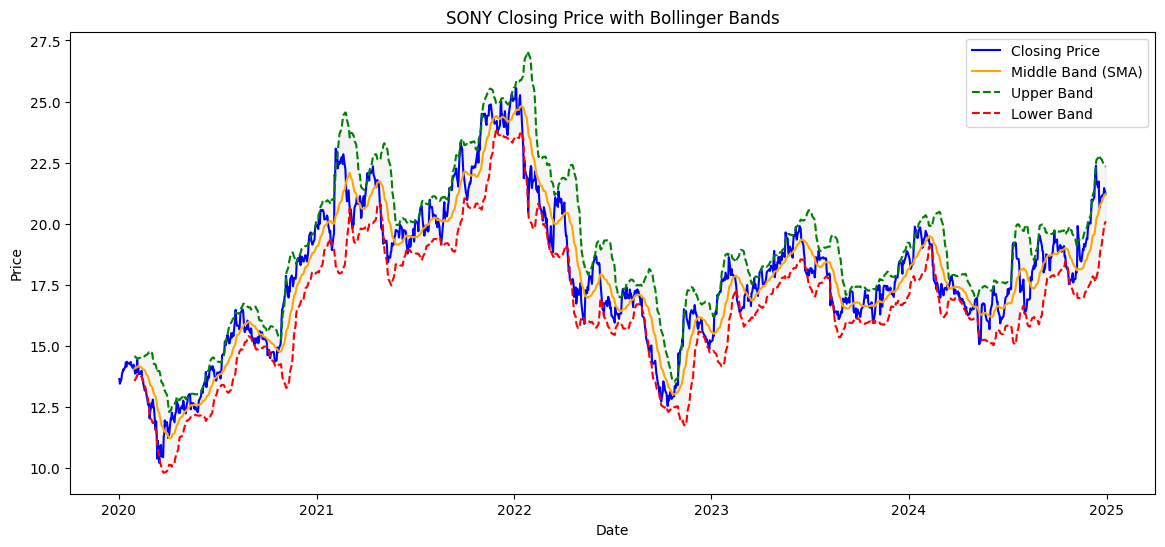

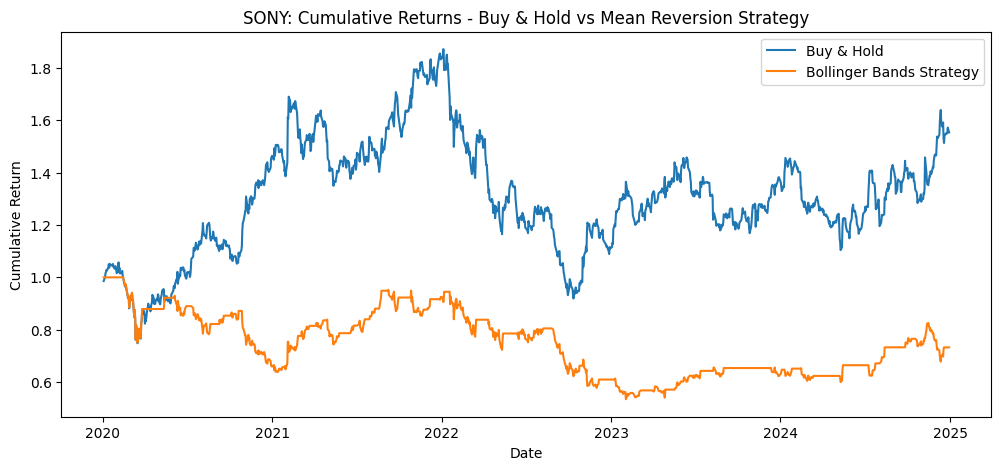

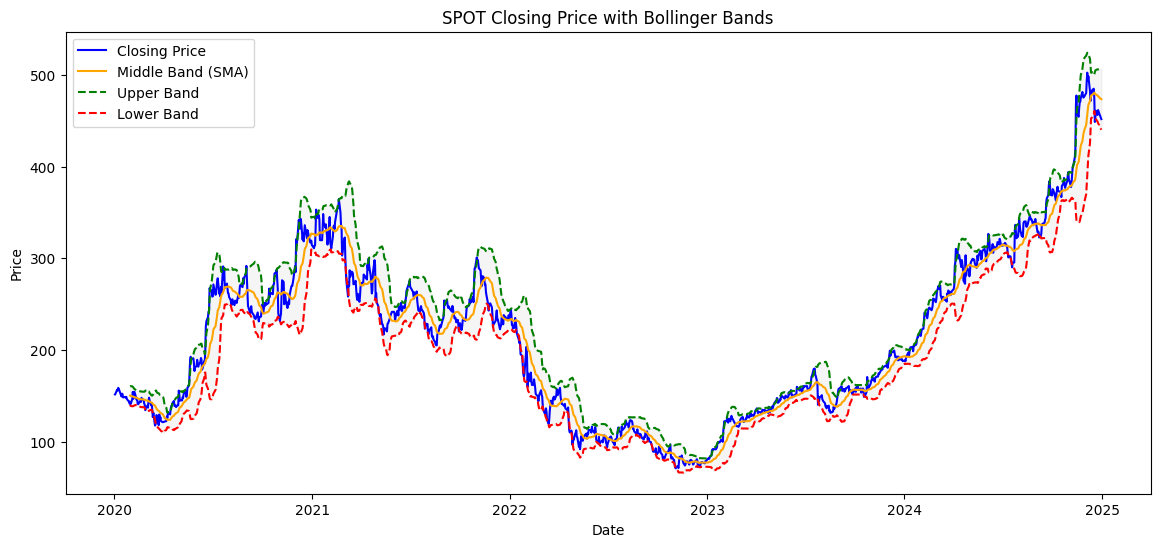

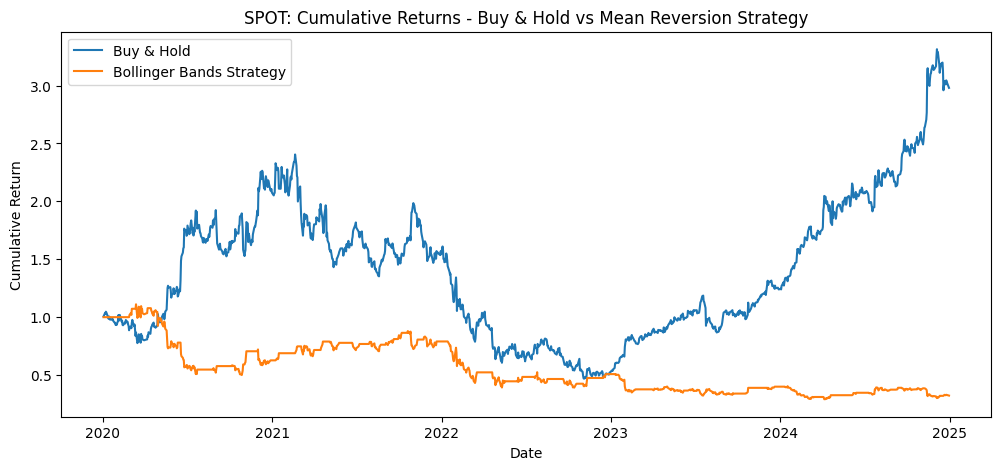

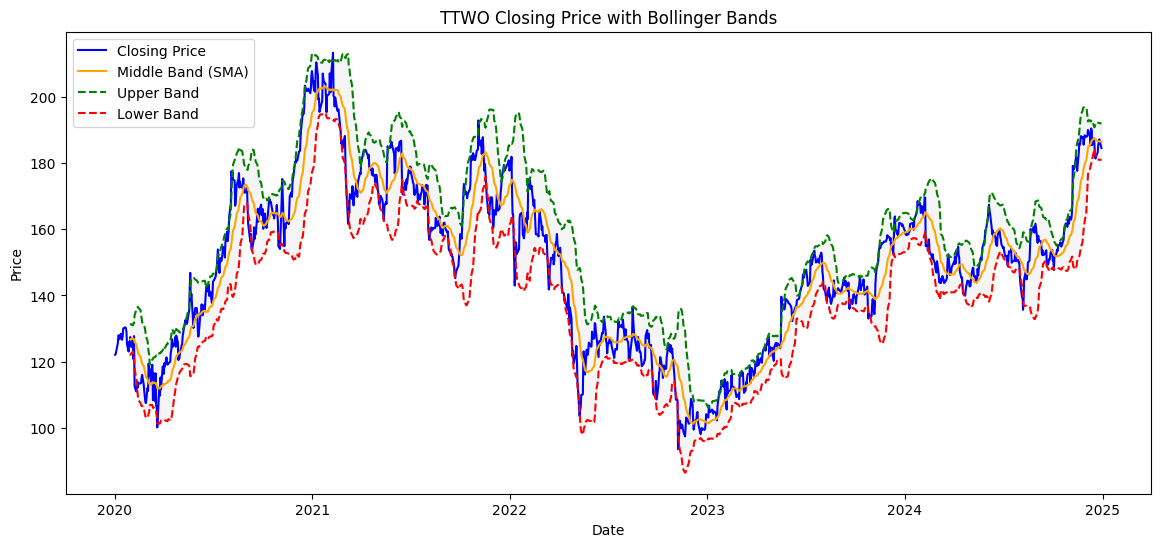

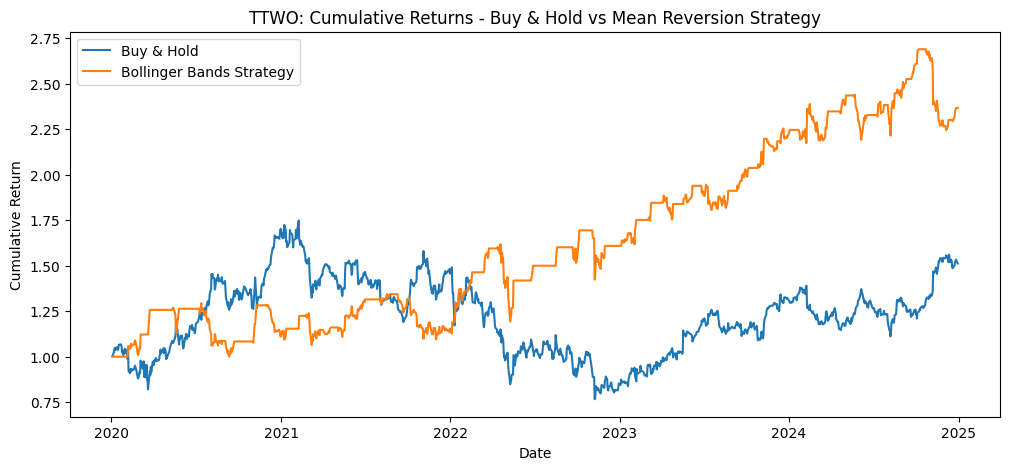

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_clean contains your 10 stocks' closing prices (columns = ticker symbols)

results = {}

for stocks in df_clean.columns:
    df = pd.DataFrame(df_clean[stocks])
    df.rename(columns={stocks: 'Close'}, inplace=True)

    # 1. Calculate Bollinger Bands (20-day SMA, ±2 std)
    window = 20
    df['SMA'] = df['Close'].rolling(window).mean()
    df['STD'] = df['Close'].rolling(window).std()
    df['Upper'] = df['SMA'] + 2 * df['STD']
    df['Lower'] = df['SMA'] - 2 * df['STD']

    # 2. Generate Entry Signals
    df['Signal'] = 0
    df.loc[df['Close'] < df['Lower'], 'Signal'] = 1    # Buy signal
    df.loc[df['Close'] > df['Upper'], 'Signal'] = -1   # Sell signal

   # 3. Generate Exit Signals & Track Position
    df['Position'] = 0  # 1 for long, -1 for short, 0 for out
    position = 0
    for i in range(1, len(df)):
        if position == 0:
            if df['Signal'].iloc[i] == 1:
                position = 1   # Enter long
            elif df['Signal'].iloc[i] == -1:
                position = -1  # Enter short
        elif position == 1:
            # Exit Buy Position when price rises back to (or above) the SMA
            if df['Close'].iloc[i] >= df['SMA'].iloc[i]:
                position = 0
        elif position == -1:
            # Exit Sell Position when price falls back to (or below) the SMA
            if df['Close'].iloc[i] <= df['SMA'].iloc[i]:
                position = 0
        df.iloc[i, df.columns.get_loc('Position')] = position

    # 4. Calculate daily returns and strategy returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy'] = df['Position'].shift(1) * df['Returns']

    # 5. Cumulative returns for both strategies
    df['BuyHold'] = (1 + df['Returns']).cumprod()
    df['StratCum'] = (1 + df['Strategy']).cumprod()

    # Store DataFrame in dictionary
    results[stocks] = df

    # 6. Plot: Closing price and Bollinger Bands
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Close'], label='Closing Price', color='blue')
    plt.plot(df.index, df['SMA'], label='Middle Band (SMA)', color='orange')
    plt.plot(df.index, df['Upper'], label='Upper Band', color='green', linestyle='--')
    plt.plot(df.index, df['Lower'], label='Lower Band', color='red', linestyle='--')
    plt.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.08)
    plt.title(f"{stocks} Closing Price with Bollinger Bands")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

    # 7. Plot: Cumulative returns of Buy & Hold vs Strategy
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['BuyHold'], label='Buy & Hold')
    plt.plot(df.index, df['StratCum'], label='Bollinger Bands Strategy')
    plt.title(f"{stocks}: Cumulative Returns - Buy & Hold vs Mean Reversion Strategy")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

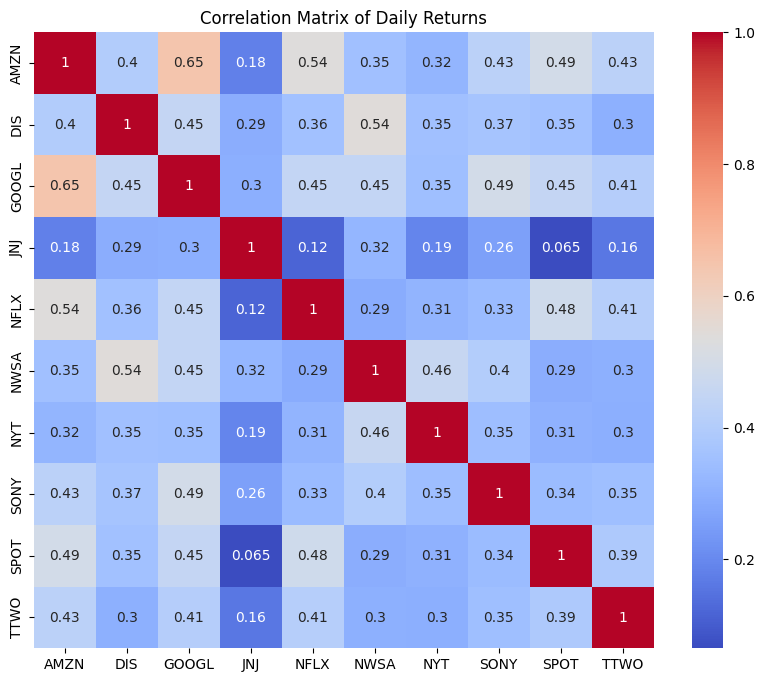

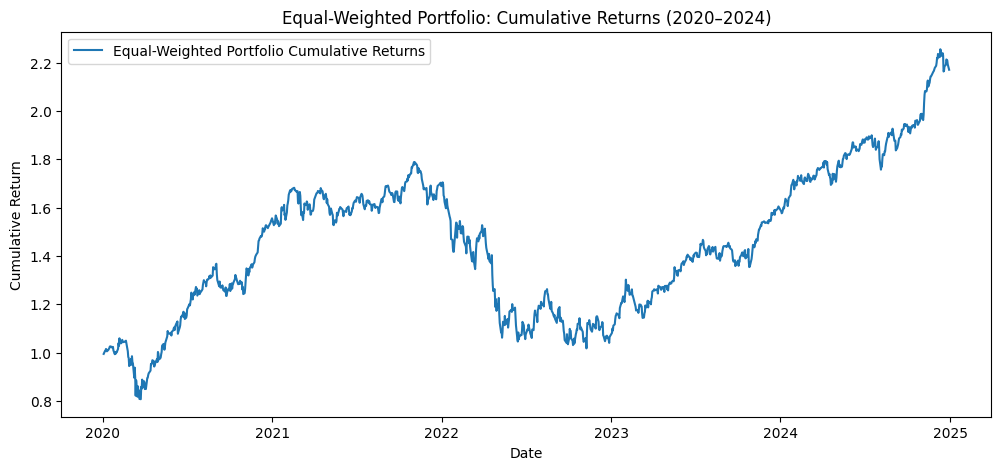

Portfolio daily standard deviation (risk): 0.01452
Portfolio annualized standard deviation (risk): 0.23048

Portfolio Returns Summary:
count    1256.000000
mean        0.000723
std         0.014519
min        -0.082860
25%        -0.006643
50%         0.001431
75%         0.008361
max         0.077713
dtype: float64


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualise correlation matrix of simple daily returns

# Calculate daily returns for all stocks
returns = df_clean.pct_change().dropna()

plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

# 2. Create equal-weighted portfolio

num_stocks = returns.shape[1]
equal_weights = np.repeat(1/num_stocks, num_stocks)  # Array of 1/10 if 10 stocks

# 3. Calculate portfolio daily returns and cumulative returns

# Multiply returns by equal weights and sum across columns to get portfolio return
portfolio_returns = returns.dot(equal_weights)
portfolio_cum_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(portfolio_cum_returns, label="Equal-Weighted Portfolio Cumulative Returns")
plt.title("Equal-Weighted Portfolio: Cumulative Returns (2020–2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# 4. Calculate risk: daily standard deviation of portfolio returns

portfolio_daily_std = portfolio_returns.std()
portfolio_annualized_std = portfolio_returns.std() * np.sqrt(252)  # 252 trading days/year

print(f"Portfolio daily standard deviation (risk): {portfolio_daily_std:.5f}")
print(f"Portfolio annualized standard deviation (risk): {portfolio_annualized_std:.5f}")

# (Optional: Show summary statistics)
print("\nPortfolio Returns Summary:")
print(portfolio_returns.describe())

In [18]:
# Portfolio Optimisation
import numpy as np
from scipy.optimize import minimize

# Use the daily returns calculated earlier
returns = df_clean.pct_change().dropna()

# Annualization factors for daily data (if you want annualized Sharpe)
trading_days = 252

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the function to minimize (negative Sharpe Ratio)
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free=0.0):
    """
    Objective function for optimization: negative Sharpe ratio.
    """
    port_return = np.dot(weights, mean_returns) * trading_days  # annualized return
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_days, weights)))
    # Avoid division by zero:
    if port_vol == 0:
        return 0
    return -(port_return - risk_free) / port_vol

num_assets = len(mean_returns)
init_guess = num_assets * [1. / num_assets]  # start with equal weights
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Run the optimizer
opt_result = minimize(neg_sharpe, init_guess, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

opt_weights = opt_result.x

# Make results more readable:
opt_weights_df = pd.DataFrame({'Stock': returns.columns, 'Sharpe_Opt_Weight': opt_weights})

print(opt_weights_df)

   Stock  Sharpe_Opt_Weight
0   AMZN       1.820375e-17
1    DIS       0.000000e+00
2  GOOGL       4.123690e-01
3    JNJ       6.791545e-18
4   NFLX       1.774134e-01
5   NWSA       1.757438e-01
6    NYT       6.202219e-02
7   SONY       2.432153e-17
8   SPOT       1.724516e-01
9   TTWO       4.373507e-18


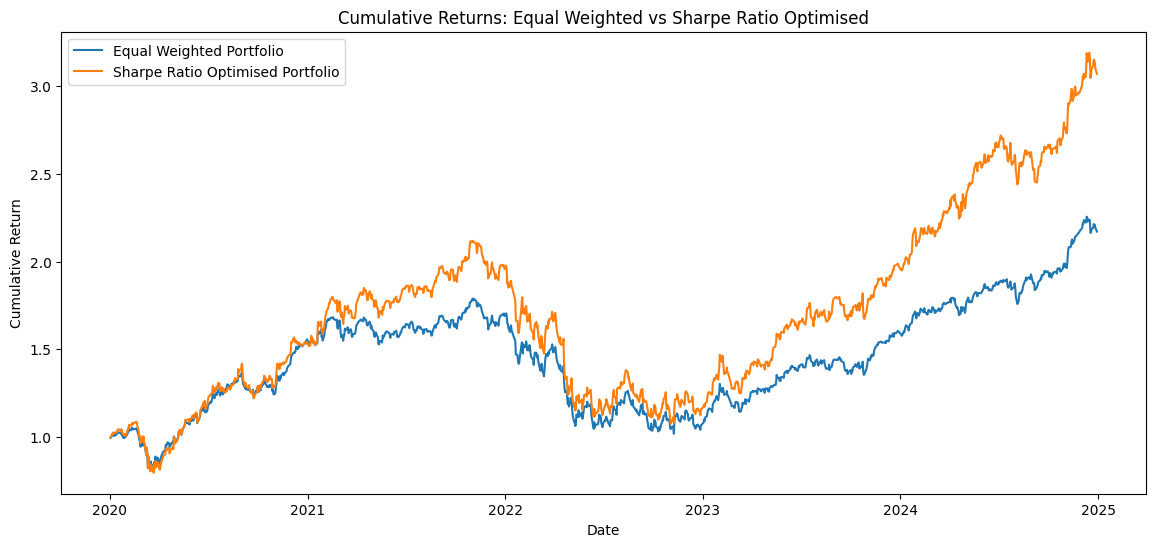

In [19]:
# Sharpe-optimised portfolio returns
sharpe_port_returns = returns.dot(opt_weights)
sharpe_port_cum = (1 + sharpe_port_returns).cumprod()

# Equal weighted portfolio
equal_weights = np.repeat(1/num_assets, num_assets)
equal_port_returns = returns.dot(equal_weights)
equal_port_cum = (1 + equal_port_returns).cumprod()

# (AI-generated approach will be added below after Copilot code)

# Plot for comparison
plt.figure(figsize=(14,6))
plt.plot(equal_port_cum, label='Equal Weighted Portfolio')
plt.plot(sharpe_port_cum, label='Sharpe Ratio Optimised Portfolio')
plt.title("Cumulative Returns: Equal Weighted vs Sharpe Ratio Optimised")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [30]:
# AI generated example
# Risk parity: Each asset should contribute equally to portfolio volatility.
def risk_contribution(weights, cov_matrix):
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_days, weights)))
    # Marginal risk contribution for each asset:
    mrc = np.dot(cov_matrix * trading_days, weights) / port_vol
    rc = weights * mrc
    # Objective: sum of squared deviations from average risk contribution
    target = port_vol / len(weights)
    return ((rc - target)**2).sum()

risk_parity_result = minimize(risk_contribution, init_guess, args=(cov_matrix,),
                              method='SLSQP', bounds=bounds, constraints=constraints)

risk_parity_weights = risk_parity_result.x

# Cumulative returns
risk_parity_port_returns = returns.dot(risk_parity_weights)
risk_parity_port_cum = (1 + risk_parity_port_returns).cumprod()

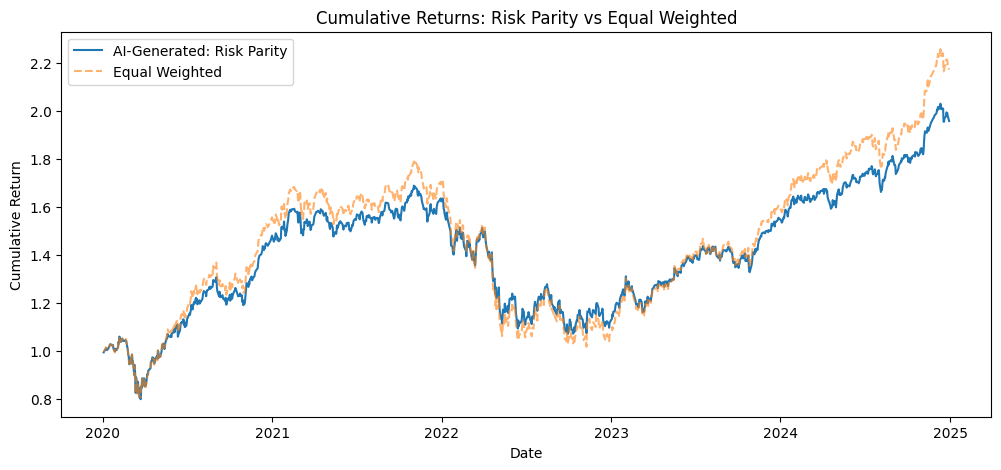

In [29]:
# Risk parity: Equalise the risk each asset contributes to total volatility
def risk_contribution(weights, cov_matrix):
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_days, weights)))
    mrc = np.dot(cov_matrix * trading_days, weights) / port_vol
    rc = weights * mrc
    target = port_vol / len(weights)
    return ((rc - target)**2).sum()

risk_parity_result = minimize(risk_contribution, init_guess, args=(cov_matrix,),
                              method='SLSQP', bounds=bounds, constraints=constraints)

risk_parity_weights = risk_parity_result.x

# Calculate returns
risk_parity_port_returns = returns.dot(risk_parity_weights)
risk_parity_port_cum = (1 + risk_parity_port_returns).cumprod()

# Visualise
plt.figure(figsize=(12,5))
plt.plot(risk_parity_port_cum, label='AI-Generated: Risk Parity')
plt.plot(equal_port_cum, label='Equal Weighted', linestyle='--', alpha=0.6)
plt.title("Cumulative Returns: Risk Parity vs Equal Weighted")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()